In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import numpy as np
import astropy.io.fits
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
import scipy.stats as stats
from astropy.stats import sigma_clip
from colossus.halo import profile_nfw
import sherpa.astro.ui as ui
cosmo = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology
c=const.c.to("km/s").value
%matplotlib inline


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
col1_data = []
col2_data = []
col3_data = []
with open('newcluster.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        col1_data.append(float(row[0]))
        col2_data.append(float(row[1]))
        col3_data.append(float(row[2]))
        
RA=np.array(col1_data )
DEC=np.array(col2_data) 
Z= np.array(col3_data)

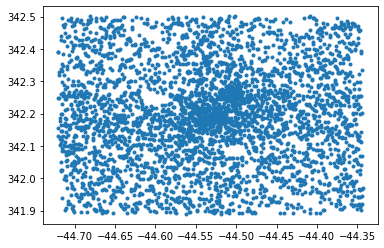

In [3]:
plt.plot(DEC,RA,'.')

In [4]:
# Create a boolean mask for values within the desired range
mask = np.logical_and(Z >= 0.32, Z <= 0.36)

# Use the mask to get only the values within the desired range
z = Z[mask]

In [5]:
ra= RA[mask]
dec=DEC[mask]
ra_cl=np.mean(RA[mask])
dec_cl=np.mean(DEC[mask])
z_cl = 0.3457
len(ra),len(dec),len(z)

(1273, 1273, 1273)

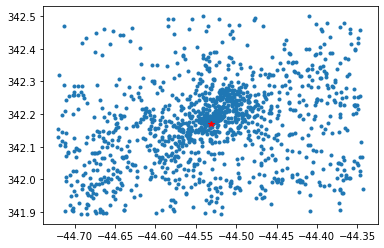

In [6]:
# projection of the cluster
plt.plot(dec,ra,'.')
plt.plot(dec_cl,ra_cl,'*',color='red')

In [7]:
len(ra),len(dec),len(z)
c1 = SkyCoord(ra=ra*u.degree, dec=dec*u.degree ,frame='icrs')
c2 = SkyCoord(ra=ra_cl*u.degree, dec=dec_cl*u.degree, frame='icrs')
sep = c1.separation(c2)
sep_radian=sep.radian 

# proj distance
r_proj=(sep_radian* cosmo.angular_diameter_distance(z_cl)/u.radian).value
r_proj.max()

5.105460408435403

In [8]:
# From astropy inbuilt module separation
coordinates_SubHaloes = SkyCoord( ra , dec , unit='deg', frame='icrs')
coordinate_cluster    = SkyCoord( ra_cl , dec_cl, unit='deg', frame='icrs')
Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)
Angular_separation_Astropy_radian.value

# Comoving distance
D = cosmo.comoving_distance(z_cl)
print('the cluster at redshift ',z_cl,' is at dC=',D)

# The angular separation between sub haloes and the cluster converted in Mpc
r_proj = (Angular_separation_Astropy_radian * cosmo.angular_diameter_distance(z_cl)/u.radian).value
print('min, max projected distance : ',r_proj.min(), r_proj.max()) #'compared to the 3D virial radius', r_cl/1000)




the cluster at redshift  0.3457  is at dC= 1402.4195481094223 Mpc
min, max projected distance :  0.05310435105103727 5.105460408435403


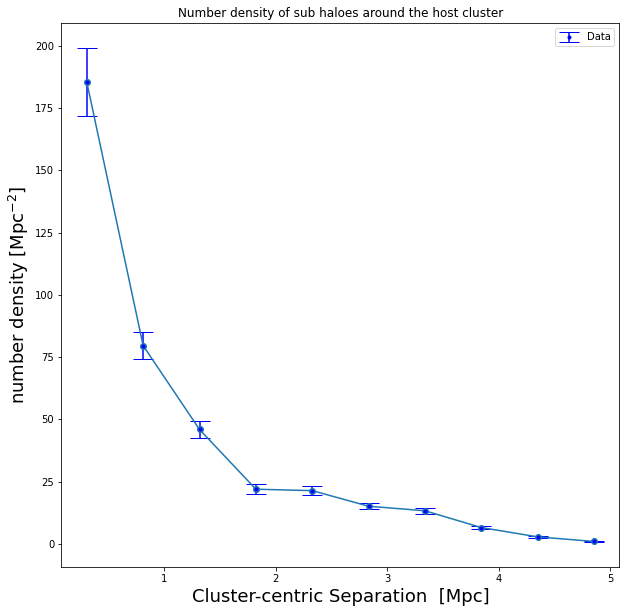

In [9]:

# number density profile

def poiss_err(n, alpha=0.32):
    """
    Poisson error (variance) for n counts.
    An excellent review of the relevant statistics can be found in
    the PDF statistics review: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf,
    specifically section 39.4.2.3
    :param: alpha corresponds to central confidence level 1-alpha,
            i.e. alpha = 0.32 corresponds to 68% confidence
    """
    sigma_lo = sp.stats.chi2.ppf(alpha/2,2*n)/2
    sigma_up = sp.stats.chi2.ppf(1-alpha/2,2*(n+1))/2
    return sigma_lo, sigma_up

# density profile
nbins=10 #number of bins
n_data,R_bins=np.histogram(r_proj, nbins, range=(r_proj.min(), r_proj.max()))
# ignore bin with zero count
select = n_data > 0
n_data = n_data[select]
R_bins_low = R_bins[:-1][select]
R_bins_high = R_bins[1:][select]

# compute poisson error  errors in n_data
n_data_low, n_data_high = poiss_err(n_data, alpha=0.32)
R_bins_ce = 0.5 * (R_bins_low + R_bins_high)

#  projected number density profile
delta_R2 = (R_bins_high**2 - R_bins_low**2)
Sig_data = n_data / (np.pi * delta_R2)
Sig_data_low = n_data_low / (np.pi * delta_R2)
Sig_data_high = n_data_high / (np.pi * delta_R2),

# error
sig_low = Sig_data - Sig_data_low
sig_high = Sig_data_high - Sig_data


# plotting the projected number density profile as a functin of r_proj
plt.figure(0, (10, 10))
plt.errorbar((R_bins_ce), Sig_data,yerr=(Sig_data - Sig_data_low),
    color='blue',  fmt='.', capsize=10, label='Data')
plt.plot(R_bins_ce,Sig_data,'o',linestyle='-')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18)
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()


In [10]:
# Peculiar velocities 

los_v = c * (z - z_cl) / (1 + z_cl)
#three different estimation based on the paper @https://articles.adsabs.harvard.edu/pdf/1990AJ....100...32B
# @https://arxiv.org/abs/2006.05949
# power law to fit the profile
def sigma_v(r,v_0):
    beta=0.1
    return v_0 / (1+ r) ** beta

# biweight estimates of the velocity dispersion
def biweight_vdisp(v):
    
    if v.size > 2:
        sigma = biweight_scale(v, 9)
        return sigma
    
def biweight_est_error(v):
    sigma_err = 0.92 * sigma / (np.sqrt(v.size - 1))
    return sigma_err

def gapper_vdisp(v):
   
    v = np.sort(v)
    n = len(v)
    w = np.arange(1, n) * np.arange(n - 1, 0, -1)
    g = np.diff(v)
    return (np.sqrt(np.pi)) / (n * (n - 1)) * np.sum(w * g)

def sigma_std(v):
    return np.std(v)

def avg_vel(v):
    return np.sqrt(np.average((los_v**2)))

# sigma and the error
sigma =  biweight_scale(los_v)
sigma_err = 0.92 * sigma / (np.sqrt(los_v.size - 1))
sigma,sigma_err,biweight_vdisp(los_v),gapper_vdisp(los_v),sigma_std(los_v),avg_vel(los_v)


# r200 of the cluster using the velocity as well as the redshift (Alex Saro 2013  )
def rho_crit(z):
    return cosmo.critical_density(z).to_value('Msun/Mpc3')

def r200_from_sigma(sigma, z):
    G = const.G.to_value('km^2 Mpc / (Msun s^2)')
    H = cosmo.H(z).to_value('km/s/Mpc')
    delta_c = 200
    rho_c = rho_crit(z)
    r200 = np.sqrt(3 * sigma**2 / (10 * G * delta_c * rho_c))
    return r200

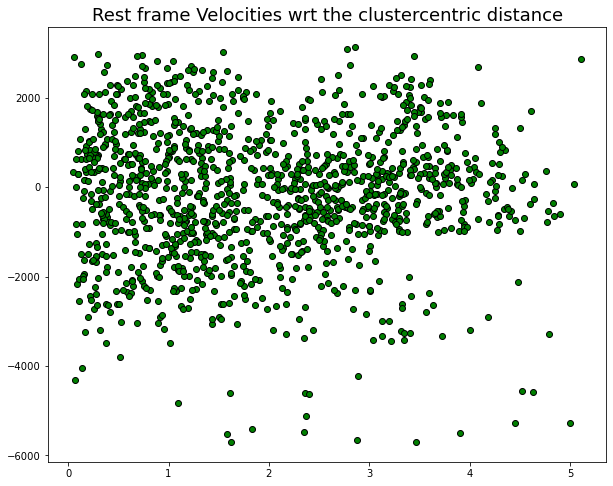

In [11]:
plt.figure(figsize=(10,8))

plt.title('Rest frame Velocities wrt the clustercentric distance',fontsize=18)
plt.plot(r_proj,los_v, color='black', linestyle='none', linewidth = 2, marker='.', markerfacecolor='green', markersize=12)
#plt.ylim(-5000,5000)

In [12]:
import numpy as np
from astropy.stats import biweight_location, biweight_midvariance
from scipy.optimize import curve_fit

def compute_profile(proj_radius, los_v, nbins, method='std'):
    """
    Compute a profile by computing the standard deviation or biweight estimate of
    the velocity in each bin, and fitting a power-law model to the profile.
    
    Parameters:
    -----------
    proj_radius : array_like
        Array of projected radii.
    los_v : array_like
        Array of line-of-sight velocities.
    nbins : int
        Number of bins to use in computing the profile.
    method : {'std', 'biweight'}, optional
        Method to use for computing the velocity dispersion in each bin. Default is 'std'.
    
    Returns:
    --------
    tuple
        A tuple containing the following elements:
        - bin_centers : array_like
            The centers of the bins used in computing the profile.
        - v_disp : array_like
            The velocity dispersion in each bin.
        - alpha, alpha_err : float
            The power-law index and its uncertainty, respectively.
    """
    # Sort the data by projected radius
    idx = np.argsort(proj_radius)
    proj_radius = proj_radius[idx]
    los_v = los_v[idx]
    
    # Compute the bin edges and centers
    bin_edges = np.linspace(np.min(proj_radius), np.max(proj_radius), nbins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    # Compute the velocity dispersion in each bin
    v_disp = np.zeros(nbins)
    for i in range(nbins):
        mask = np.logical_and(proj_radius >= bin_edges[i], proj_radius < bin_edges[i+1])
        if method == 'std':
            v_disp[i] = np.std(los_v[mask])
        elif method == 'biweight':
            v_disp[i] = biweight_midvariance(los_v[mask])**0.5
    
    # Fit a power-law model to the profile
    def powerlaw(x, a, b):
        return a * x**b
    
    popt, pcov = curve_fit(powerlaw, bin_centers, v_disp)
    alpha, alpha_err = popt[1], np.sqrt(np.diag(pcov))[1]
    
    return bin_centers, v_disp, alpha, alpha_err
bin_centers, v_disp, alpha, alpha_err =compute_profile(r_proj,los_v,10)

In [13]:
compute_profile(r_proj,los_v,10)

(array([0.30572215, 0.81095776, 1.31619337, 1.82142897, 2.32666458,
        2.83190018, 3.33713579, 3.84237139, 4.347607  , 4.85284261]),
 array([1567.71716605, 1516.55082806, 1468.26176522, 1618.08831431,
        1315.19275346, 1314.15447957, 1511.95857023, 1264.94143106,
        1397.33628786, 1884.33546992]),
 -0.012174617966121936,
 0.04948110092118627)

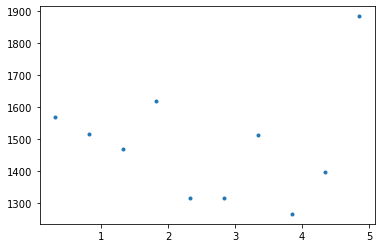

In [14]:
plt.plot(bin_centers, v_disp,'.')

In [15]:
cluster_data=np.vstack((ra,dec,z)).T
len(cluster_data)

1273

In [16]:
import causticpy
caustic= causticpy.Caustic()
caustic.run_caustic(cluster_data)


DATA SET SIZE 1152
Pre_r200= 1.8873638273329176
Calculating Density w/Mirrored Data
Vdisp from galaxies= 1524.6503305402891
Combined Vdisp= 1524.6503305402891
Calculating initial surface
complete


1

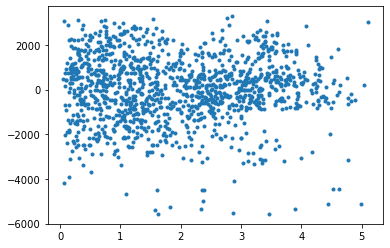

In [17]:
caustic.r.max(),r_proj.min()
plt.plot(caustic.r,caustic.v,'.',linestyle='none')

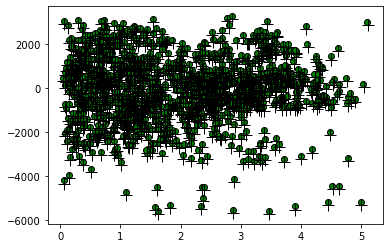

In [18]:
plt.plot(caustic.r,caustic.v,color='black', linestyle='none', linewidth = 2, marker='.', markerfacecolor='green', markersize=12)
plt.plot(r_proj,los_v,color='black', linestyle='none', linewidth = 2, marker='+', markerfacecolor='red', markersize=12)


In [19]:
caustic.run_caustic(cluster_data,clus_ra=caustic.clus_ra,clus_dec=caustic.clus_dec,clus_z=caustic.clus_z)

DATA SET SIZE 1152
Pre_r200= 1.8873638273329176
Calculating Density w/Mirrored Data
Vdisp from galaxies= 1524.6503305402891
Combined Vdisp= 1524.6503305402891
Calculating initial surface
complete
r200 estimate:  2.043193553165391
M200 estimate:  2692467100907900.5


1

In [20]:
caustic.r200_est

array(2.02570578)

In [21]:
caustic.M200_est/ 1e15

2.623256598916788

In [22]:
caustic.angle
z_cl=caustic.clus_z
caustic.ang_d
caustic.lum_d
caustic.v
caustic.data_set.T # velocities of the galaxies after clipping
caustic.x_range
caustic.y_range
caustic.img_tot
caustic.caustic_profile
caustic.caustic_fit
caustic.gal_vdisp
caustic.memflag

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

<function matplotlib.pyplot.show(*, block=None)>

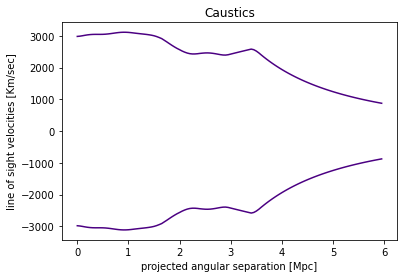

In [23]:
plt.title('Caustics')
caustic_profile=caustic.caustic_profile
caustic_radii=caustic.x_range
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo')  # assumes caustic
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel('line of sight velocities [Km/sec]')
plt.show

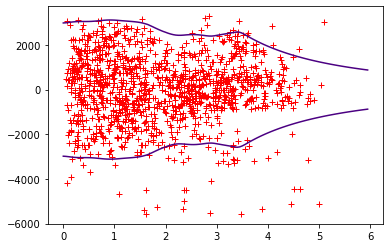

In [24]:
plt.plot(caustic.r,caustic.v,color='red', linestyle='none',marker='+')
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo') 

In [25]:
projected_radius=np.array(caustic.r)
peculiar_velocity=np.array(los_v)
cluster_redshift=caustic.clus_z
cluster_RA=caustic.clus_ra
cluster_DEC=caustic.clus_dec

caustic_profile=caustic.caustic_profile

caustic_mask = np.array([x==1 for x in caustic.memflag])
cut_radius = np.transpose(caustic.data_set)[0]
cut_velocity = np.transpose(caustic.data_set)[1]
cut_RA = np.transpose(caustic.data_set)[2]
cut_DEC = np.transpose(caustic.data_set)[3]
cut_z = np.transpose(caustic.data_set)[4]

trimmed_radius = cut_radius[caustic_mask]
trimmed_velocity = cut_velocity[caustic_mask]

<function matplotlib.pyplot.show(*, block=None)>

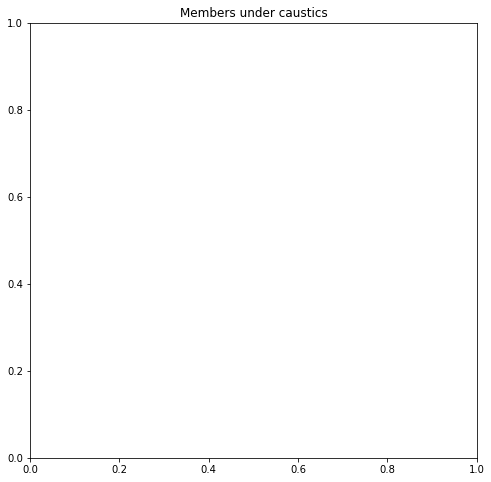

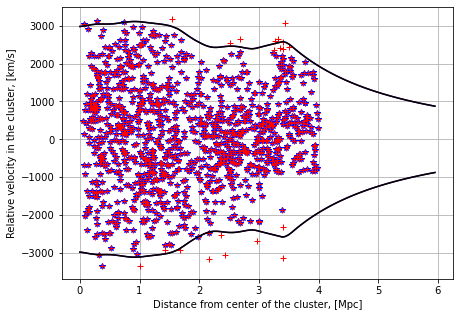

In [26]:
# plot the original and rejected data
plt.figure(figsize=(8,8))
plt.title('Members under caustics')
fig, ax = plt.subplots(1, 1, figsize=(7,5))
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo')
plt.plot(trimmed_radius,trimmed_velocity,'*',color='blue',)
plt.plot(cut_radius,cut_velocity, '+', color='red', label="original data")
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel('line of sight velocities [Km/sec]')
ax.plot(caustic.x_range, caustic.caustic_profile, c='black')
ax.plot(caustic.x_range, -caustic.caustic_profile, c='black')
ax.set_xlabel('Distance from center of the cluster, [Mpc]')
ax.set_ylabel('Relative velocity in the cluster, [km/s]')
ax.grid(True)
plt.show


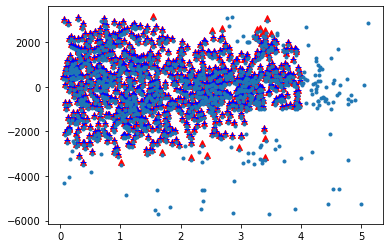

In [27]:
plt.plot(cut_radius, cut_velocity, '^', color='red')
plt.plot(trimmed_radius, trimmed_velocity, '+',color='blue')
plt.plot(r_proj,los_v,'.')


In [28]:
h0=67.77
class MassCalc:
    """
    MassCalc(self,ri,A,vdisp,r200=None,conc1=None,beta=None,fbr=None):

        ri - rgrid values

        A - caustic profile values

        vdisp - galaxy velocity dispersion

        r200 = 2.0 - critical radius of cluster. Default is 2.0, but advised to take the output r200 and rerun
        the analysis with this better estimate.

        conc1 = None - concentration of cluster. If None given then calculated from relationship

        beta = 0.2 - Anisotrpy parameter. Default value is 0.2, but a profile can be given that has same xvalues as ri.

        fbr = None - An exact guess of Fbeta by whatever means. Usually not used.

        H0 = 100.0 - Hubble constant
    """
    
    def __init__(self,ri,A,vdisp,clus_z,r200=None,conc1=None,beta=0.25,fbr=None,H0=h0):
        "Calculate the mass profile"
        G = 6.67E-11
        solmass = 1.98892e30
        self.crit = 2.7745946e11*(H0/100.0)**2.0*(0.25*(1+clus_z)**3.0 + 0.75)
        r2 = ri[ri>=0]
        A2 = A[ri>=0]
        kmMpc = 3.08568025e19
        sumtot = np.zeros(A2.size)
        #print 'Using beta = %.2f'%(beta)
        if conc1 == None:
            #self.conc = 4.0*(vdisp/700.0)**(-0.306)
            self.conc = 5.0 + np.random.normal(0,2.0)
            if self.conc <= 0: self.conc = 5.0
        else:
            self.conc = conc1
        beta = 0.5*(ri/(ri+r200/self.conc))
        self.g_b = (3-2.0*beta)/(1-beta)
        if fbr is None:
            self.f_beta = 0.5*((r2/r200*self.conc)**2)/((1+((r2/r200*self.conc)))**2*np.log(1+((r2/r200*self.conc))))*self.g_b
            self.f_beta[0] = 0
            for i in range(A2.size-1):
                i += 1    
                sumtot[i] = np.trapz(self.f_beta[1:i+1]*(A2[1:i+1]*1000)**2,(r2[1:i+1])*kmMpc*1000)
                #sum[i] = np.trapz((A2[:i+1]*1000)**2,(r2[:i+1])*kmMpc*1000)
            #sum = integrate.cumtrapz(self.f_beta*(A2[:f_beta.size]*1000)**2,r2[:f_beta.size]*kmMpc*1000,initial=0.0)
        else:
            if type(fbr) == float or type(fbr) == int or type(fbr) == np.float64:
                self.f_beta = np.zeros(A2.size)+fbr*1.0
            else:
                self.f_beta = fbr
            self.f_beta[0] = 0
            for i in range(A2.size-1):
                i += 1    
                sumtot[i] = np.trapz(self.f_beta[1:i+1]*(A2[1:i+1]*1000)**2,(r2[1:i+1])*kmMpc*1000)
                #sum[i] = np.trapz((A2[:i+1]*1000)**2,(r2[:i+1])*kmMpc*1000)
            #sum = integrate.cumtrapz(self.f_beta*(A2[:f_beta.size]*1000)**2,r2[:f_beta.size]*kmMpc*1000,initial=0.0)
        self.massprofile = sumtot/(G*solmass)
        
        #return the caustic r200
        self.avg_density = self.massprofile/(4.0/3.0*np.pi*(ri[:self.f_beta.size])**3.0)
        try:
            #self.r200_est = (ri[:self.f_beta.size])[np.where(self.avg_density >= 200*self.crit)[0]+1][-1]
            finterp = interp1d(self.avg_density[::-1],ri[:self.f_beta.size][::-1])
            self.r200_est = finterp(200*self.crit)
            self.r500_est = finterp(500*self.crit)
        except IndexError:
            self.r200_est = 0.0
            self.r500_est = 0.0
        #self.M200_est = self.massprofile[np.where(ri[:self.f_beta.size] <= self.r200_est)[0][-1]]
        finterp = interp1d(ri[:self.f_beta.size],self.massprofile)
        self.M200_est = finterp(self.r200_est)
        self.M500_est = finterp(self.r500_est)
        self.M200 = self.massprofile[np.where(ri[:self.f_beta.size] <= r200)[0][-1]]
        

In [29]:
m = MassCalc(ri =caustic.x_range,
    A = caustic.caustic_profile,
    vdisp = caustic.vdisp_gal,
    clus_z = caustic.clus_z,
    r200=caustic.r200,
    conc1=5,
    beta=0.33,
    fbr=None,
    H0=67.77,)

In [30]:
caustic.beta

array([0.        , 0.04790732, 0.0874369 , 0.12060962, 0.14884475,
       0.17316834, 0.19434056, 0.21293658, 0.22939964, 0.24407681,
       0.25724374, 0.26912212, 0.27989227, 0.28970238, 0.29867534,
       0.30691392, 0.31450473, 0.32152128, 0.32802636, 0.33407393,
       0.33971062, 0.34497692, 0.34990817, 0.35453538, 0.35888581,
       0.36298358, 0.36685008, 0.37050435, 0.3739634 , 0.37724245,
       0.38035522, 0.38331403, 0.38613002, 0.38881331, 0.39137304,
       0.39381757, 0.39615449, 0.39839077, 0.40053276, 0.4025863 ,
       0.40455677, 0.40644911, 0.40826786, 0.41001724, 0.41170115,
       0.41332319, 0.41488672, 0.41639484, 0.41785044, 0.41925622,
       0.4206147 , 0.42192823, 0.42319899, 0.42442905, 0.42562033,
       0.42677464, 0.42789366, 0.428979  , 0.43003215, 0.43105452,
       0.43204744, 0.43301217, 0.43394989, 0.43486172, 0.43574872,
       0.43661189, 0.43745217, 0.43827046, 0.43906762, 0.43984446,
       0.44060173, 0.44134018, 0.44206049, 0.44276332, 0.44344

In [31]:
m.crit,m.conc,m.f_beta

(173099882905.34204,
 5,
 array([0.        , 0.16839211, 0.29088477, 0.3825652 , 0.45273116,
        0.50739122, 0.55058137, 0.58510093, 0.61294461, 0.63556688,
        0.65404962, 0.66921158, 0.68168189, 0.69195051, 0.70040365,
        0.70734897, 0.713034  , 0.7176596 , 0.72139005, 0.72436073,
        0.72668392, 0.72845329, 0.72974747, 0.73063276, 0.73116536,
        0.73139309, 0.73135683, 0.73109166, 0.73062776, 0.72999122,
        0.72920462, 0.7282876 , 0.72725725, 0.72612851, 0.72491442,
        0.72362645, 0.72227467, 0.72086793, 0.71941404, 0.7179199 ,
        0.71639161, 0.71483456, 0.71325353, 0.71165276, 0.71003602,
        0.70840665, 0.70676763, 0.70512158, 0.70347087, 0.70181758,
        0.70016356, 0.69851048, 0.69685979, 0.6952128 , 0.69357067,
        0.69193442, 0.69030496, 0.68868309, 0.68706952, 0.68546488,
        0.6838697 , 0.68228446, 0.68070958, 0.67914543, 0.6775923 ,
        0.67605046, 0.67452014, 0.67300153, 0.67149478, 0.67000001,
        0.66851733, 0.6

In [32]:
m.avg_density

array([           nan, 0.00000000e+00, 5.73281582e+15, 4.21132476e+15,
       3.10314352e+15, 2.37501784e+15, 1.87812299e+15, 1.52400444e+15,
       1.26228068e+15, 1.06313795e+15, 9.08057943e+14, 7.84989387e+14,
       6.85756920e+14, 6.04614780e+14, 5.37410429e+14, 4.81089444e+14,
       4.33372823e+14, 3.92525646e+14, 3.57217195e+14, 3.26427991e+14,
       2.99371121e+14, 2.75434859e+14, 2.54139864e+14, 2.35111967e+14,
       2.18050692e+14, 2.02702793e+14, 1.88852516e+14, 1.76313829e+14,
       1.64923797e+14, 1.54541265e+14, 1.45042352e+14, 1.36314783e+14,
       1.28262465e+14, 1.20810208e+14, 1.13880440e+14, 1.07413051e+14,
       1.01373000e+14, 9.57291660e+13, 9.04571163e+13, 8.55344720e+13,
       8.09409180e+13, 7.66531037e+13, 7.26496316e+13, 6.89146044e+13,
       6.54330055e+13, 6.21914988e+13, 5.91766371e+13, 5.63736940e+13,
       5.37669524e+13, 5.13391333e+13, 4.90729894e+13, 4.69525829e+13,
       4.49629944e+13, 4.30911025e+13, 4.13259256e+13, 3.96584417e+13,
      

In [33]:
m.M200_est

array(3.61313344e+15)

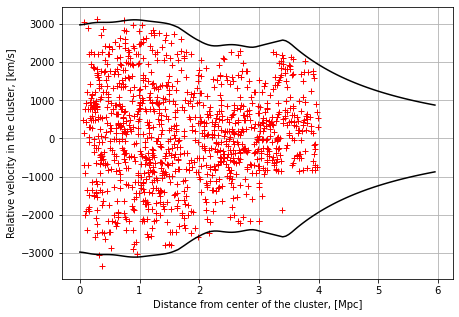

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(trimmed_radius,trimmed_velocity,'+',color='red',)

ax.plot(caustic.x_range, caustic.caustic_profile, c='black')
ax.plot(caustic.x_range, -caustic.caustic_profile, c='black')
ax.set_xlabel('Distance from center of the cluster, [Mpc]')
ax.set_ylabel('Relative velocity in the cluster, [km/s]')
ax.grid(True)

In [35]:
rr=np.linspace(0,2.63,len(m.massprofile))


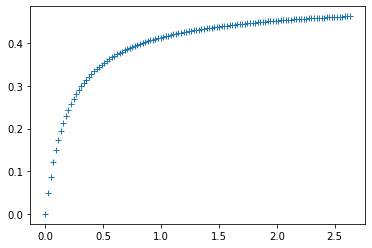

In [36]:
plt.plot(rr,caustic.beta,'+')

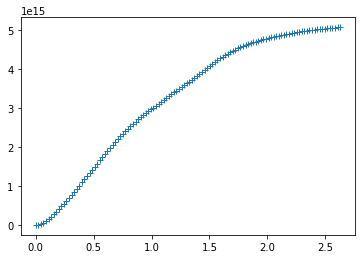

In [37]:

plt.plot(rr,m.massprofile,'+')
#plt.loglog()

In [38]:
trimmed_velocity

array([-2401.00640423, -2022.1070055 , -1910.66600588, -1910.66600588,
       -1843.80140611, -1799.22500626, -1487.19020731, -1353.46100776,
        -907.69700927,  -684.81501002,  -684.81501002,  -105.32181198,
          50.6955875 ,   139.84838719,   295.86578667,   429.59498622,
         429.59498622,   474.17138607,   763.91798509,   763.91798509,
         942.22358449,  1209.68198358,  2212.6509802 ,  2903.58517786,
        3059.60257734, -1353.46100776, -1130.57900852,   273.57758674,
         295.86578667,   474.17138607,   541.03598584,   585.61238569,
         763.91798509,   786.20618501,   853.07078479,   875.35898471,
         875.35898471,   964.51178441,   964.51178441,  1053.66458411,
        1142.81738381,  1165.10558373,  1432.56398283,  1878.32798132,
        1945.1925811 ,  2279.51557997, -2579.31200362, -2244.98900475,
       -2088.97160528, -1531.76660716, -1509.47840724, -1487.19020731,
       -1420.32560754, -1398.03740761, -1108.29080859,  -640.23861017,
      

In [39]:
import numpy as np
from astropy.stats import biweight_location, biweight_midvariance
from scipy.optimize import curve_fit

def compute_profile(proj_radius, los_v, nbins, method='std'):
    """
    Compute a profile by computing the standard deviation or biweight estimate of
    the velocity in each bin, and fitting a power-law model to the profile.
    
    Parameters:
    -----------
    proj_radius : array_like
        Array of projected radii.
    los_v : array_like
        Array of line-of-sight velocities.
    nbins : int
        Number of bins to use in computing the profile.
    method : {'std', 'biweight'}, optional
        Method to use for computing the velocity dispersion in each bin. Default is 'std'.
    
    Returns:
    --------
    tuple
        A tuple containing the following elements:
        - bin_centers : array_like
            The centers of the bins used in computing the profile.
        - v_disp : array_like
            The velocity dispersion in each bin.
        - alpha, alpha_err : float
            The power-law index and its uncertainty, respectively.
    """
    # Sort the data by projected radius
    idx = np.argsort(proj_radius)
    proj_radius = proj_radius[idx]
    los_v = los_v[idx]
    
    # Compute the bin edges and centers
    bin_edges = np.linspace(np.min(proj_radius), np.max(proj_radius), nbins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    # Compute the velocity dispersion in each bin
    v_disp = np.zeros(nbins)
    for i in range(nbins):
        mask = np.logical_and(proj_radius >= bin_edges[i], proj_radius < bin_edges[i+1])
        if method == 'std':
            v_disp[i] = np.std(los_v[mask])
        elif method == 'biweight':
            v_disp[i] = biweight_midvariance(los_v[mask])**0.5
    
    # Fit a power-law model to the profile
    def powerlaw(x, a, b):
        return a * x**b
    
    popt, pcov = curve_fit(powerlaw, bin_centers, v_disp)
    alpha, alpha_err = popt[1], np.sqrt(np.diag(pcov))[1]
    
    return bin_centers, v_disp, alpha, alpha_err


In [40]:
bin_centers, v_disp, alpha, alpha_err =compute_profile(trimmed_radius,trimmed_velocity,10)

In [41]:
bin_centers, v_disp

(array([0.24969374, 0.64299819, 1.03630263, 1.42960707, 1.82291152,
        2.21621596, 2.60952041, 3.00282485, 3.39612929, 3.78943374]),
 array([1420.97272197, 1423.78611632, 1506.16325116, 1376.10320141,
        1387.70929615, 1020.55686333,  980.07192077,  834.52608551,
         955.53026106,  788.25512431]))

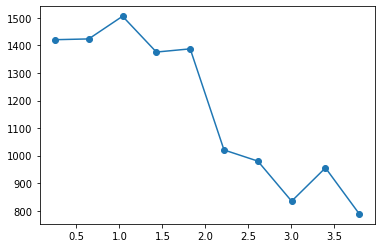

In [43]:
plt.plot(bin_centers, v_disp,'o',linestyle='-')


In [ ]:
import pandas as pd 
data = pd.read_csv("s1063.csv")
data

In [ ]:
with open('s1063.csv', 'r') as file:
        csvreader = csv.reader(file,delimiter=",")
        
        for row in csvreader:
                          
            col3_data = []
            col4_data = []
            
            for row in csvreader:
                                  
                col3_data.append(float(row[0]))
                col4_data.append(float(row[1]))


In [ ]:
plt.plot(col3_data,col4_data,'o',linestyle='-')
plt.xscale('log')

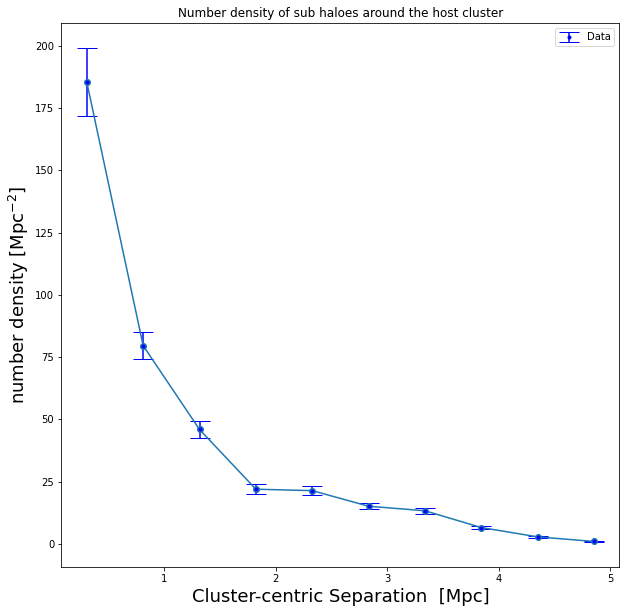

In [44]:
# number density profile

def poiss_err(n, alpha=0.32):
    """
    Poisson error (variance) for n counts.
    An excellent review of the relevant statistics can be found in
    the PDF statistics review: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf,
    specifically section 39.4.2.3
    :param: alpha corresponds to central confidence level 1-alpha,
            i.e. alpha = 0.32 corresponds to 68% confidence
    """
    sigma_lo = sp.stats.chi2.ppf(alpha/2,2*n)/2
    sigma_up = sp.stats.chi2.ppf(1-alpha/2,2*(n+1))/2
    return sigma_lo, sigma_up

# density profile
nbins=10 #number of bins
n_data,R_bins=np.histogram(r_proj, nbins, range=(r_proj.min(), r_proj.max()))
# ignore bin with zero count
select = n_data > 0
n_data = n_data[select]
R_bins_low = R_bins[:-1][select]
R_bins_high = R_bins[1:][select]

# compute poisson error  errors in n_data
n_data_low, n_data_high = poiss_err(n_data, alpha=0.32)
R_bins_ce = 0.5 * (R_bins_low + R_bins_high)

#  projected number density profile
delta_R2 = (R_bins_high**2 - R_bins_low**2)
Sig_data = n_data / (np.pi * delta_R2)
Sig_data_low = n_data_low / (np.pi * delta_R2)
Sig_data_high = n_data_high / (np.pi * delta_R2),

# error
sig_low = Sig_data - Sig_data_low
sig_high = Sig_data_high - Sig_data


# plotting the projected number density profile as a functin of r_proj
plt.figure(0, (10, 10))
plt.errorbar((R_bins_ce), Sig_data,yerr=(Sig_data - Sig_data_low),
    color='blue',  fmt='.', capsize=10, label='Data')
plt.plot(R_bins_ce,Sig_data,'o',linestyle='-')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18)
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()


In [45]:
len(v_disp),len(Sig_data)

(10, 10)

In [52]:
nn=Sig_data*v_disp**2

In [53]:
len(v_disp)
r=np.linspace(0,2.63,10)
beta_r=np.linspace(caustic.beta.min(),caustic.beta.max(),10)
beta_r

array([0.        , 0.05147364, 0.10294729, 0.15442093, 0.20589458,
       0.25736822, 0.30884186, 0.36031551, 0.41178915, 0.4632628 ])

In [57]:
dlnrho_dr = np.gradient(np.log(nn), r)
#dlnsigma2_dr = np.gradient(np.log(sigma_r**2), r)
M = (-r* v_disp**2 / const.G )* (dlnrho_dr+2*beta_r)
M


<Quantity [0.00000000e+00, 1.85071519e+16, 4.20028342e+16, 3.18301735e+16,
           4.21257281e+16, 3.39118004e+16, 3.78750859e+16, 4.30677475e+16,
           8.42791745e+16, 9.88327514e+16] kg s2 / m3>

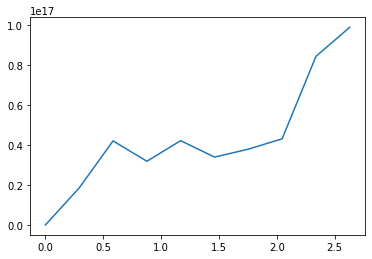

In [58]:
plt.plot(r,M)

In [ ]:
# Define the radial bins
nbins = 9
rmin = r_proj.min()
rmax = r_proj.max()
r_bins = np.linspace(rmin, rmax, nbins + 1)

# Calculate the volume of each spherical shell
volumes = (4/3) * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)

# Count the number of galaxies in each bin
hist, _ = np.histogram(r_proj, bins=r_bins)

# Calculate the number density in each bin
density = hist / volumes

# Calculate the error bars on the density using Poisson statistics
error_low = np.sqrt(hist) / volumes
error_up = np.sqrt(hist + 1) / volumes

# Plot the number density profile
radius = 0.5 * (r_bins[1:] + r_bins[:-1])
plt.errorbar(radius, density, yerr=(error_low, error_up), fmt='o',)
plt.xlabel('Radius [Mpc]')
plt.ylabel('Number Density [Mpc^-3]')
plt.show()


# $d(sigma_r^2*rho)/dr + 2 beta sigma_r^2/r = -rho d(phi)/dr$

In [ ]:
dM/dr = 4 pi r^2 rho

In [ ]:
M(r) = 4 pi rho_s r_s^3 [ln(1 + r/r_s) - (r/r_s)/(1 + r/r_s)]